In [1]:
from jax import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
from jax import jit

import jaxley as jx
from jaxley.channels import Na, K, Leak
from jaxley.synapses import IonotropicSynapse
from jaxley.connect import fully_connect, connect
from jaxley.channels import Leak, HH
%matplotlib inline
_ = np.random.seed(0)
from reaching_task import Reaching
from jaxley_utils import init_inh_ex_gS
from jax import jit, vmap, value_and_grad
from jax.tree_util import tree_map
import optax
from jaxley.optimize.utils import l2_norm


In [2]:
#https://github.com/mackelab/jaxley_experiments_internal/blob/main/paper/fig5_rnn/scripts/task_run_training.py

In [3]:
seed = 1
g_scaling = 100_000 / 2 / np.pi / 10.0 / 1.0
dt = .025
n_classes = 6
#sync_wandb=True
#sav/e_dir = "/mnt/qb/work/macke/mpals85/task_mods/"
#save_dir = "/home/matthijs/jaxley_experiments/nex/memory/models/"

# Initial RNN params
RNN_params = {
    "RNN_seed":seed,
    "seed":seed,
    "n_rec":50,
    "n_inh":10,
    "n_out":n_classes,
    "init_gain": .9/g_scaling,
    "out_scale":.2,
    "inp_scale":.5,
    "in_conn_prob":.1,
    "out_conn_prob":1,
    "rec_conn_prob":.05,
    "k_minus":1,
    "out_k_minus":.1,
}



#constraints
lowers = {"input_weights": 0, "IonotropicSynapse_gS": 0, "IonotropicSynapse_k_minus": 1/20, "v": -120.0}
uppers= {"input_weights": 4, "IonotropicSynapse_gS": None, "IonotropicSynapse_k_minus": 2.0, "v":0}

training_params={
    "lr":0.01,
    "lr_end":0.0001,
    "delay_step":4000, 
    "lowers":lowers,
    "uppers":uppers,
    "max_epochs":1250,
    "loss_threshold":.65,
    "acc_threshold":.95,
    "train_v":False,
    "train_k_minus":True,
    'checkpoint_levels':2,
}

#  task params (in ms)


trial_len = 50
onset = [5,6]
stim_dur = [10,11]
delay_dur = [20,21]
n_stim = n_classes
batch_size = 64

task_params={
        'trial_len' : int(trial_len / dt),          # total trial length in steps
        'onset'     : (int(onset[0] / dt), int(onset[1] / dt)),    # stimulus onset range in steps
        'stim_dur'  : (int(stim_dur[0] / dt), int(stim_dur[1] / dt)),  # stimulus duration range in steps
        'delay_dur' : (int(delay_dur[0] / dt), int(delay_dur[1] / dt)), # delay duration range in steps
        'n_stim'    : n_stim,                       # number of unique stimuli
        'batch_size': batch_size                    # batch size for get_batch
}


56 [56, 57] [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
15.333333333333334
828
54
conn probability recurrence: 0.2839506172839506
EIratio:4.4
Normaliser: 0.5267085409714959
Spectral radius recurrence: 0.0007991130800482155
Leak out
Leak out
Leak out
Leak out
Leak out
Leak out
56 [] [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
14.785714285714286
828
56
conn probability recurrence: 0.264030612244898
EIratio:4.6
Normaliser: 0.5111897733978055
Spectral radius recurrence: 0.0004678006174028048


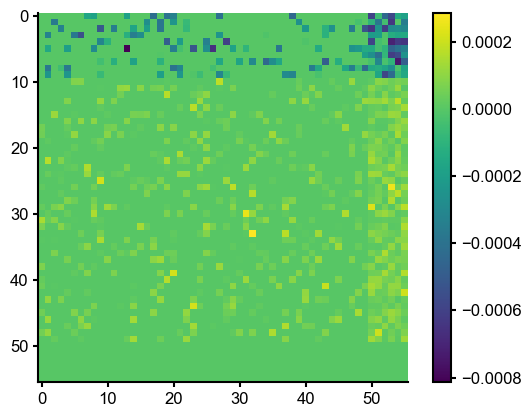

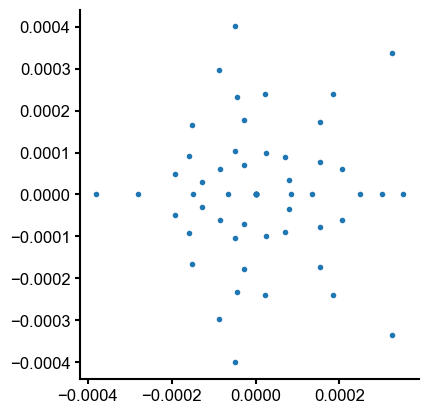

In [4]:
# Define a compartment, branch, and cell
comp = jx.Compartment()
branch = jx.Branch(comp,ncomp=1)
cell = jx.Cell(branch, parents=[-1])

num_cells=RNN_params["n_rec"]  + RNN_params["n_out"]
n_rec = RNN_params["n_rec"]
n_inh =  RNN_params["n_inh"]
n_out = RNN_params["n_out"]
init_gain=RNN_params["init_gain"]
leak_out = True
tau = 100

net = jx.Network([cell for _ in range(num_cells)])
pre = net.cell(range(num_cells-n_out))
post = net.cell(range(num_cells-n_out))
readout = net.cell([range(num_cells-n_out, num_cells)])
#fully_connect(pre, post, IonotropicSynapse())
negative_inds = np.arange(n_inh).tolist()
rec_conn_prob=.2
# Connect the somas to the apical dendrites
for i in range(num_cells-n_out):
    for j in range(num_cells-n_out):
        if np.random.binomial(1, rec_conn_prob):
            connect(
                net.cell(i).branch(0).comp(0),
                net.cell(j).branch(0).comp(0),
                IonotropicSynapse(),
            )

fully_connect(pre, readout, IonotropicSynapse())
           
conn_matrix = init_inh_ex_gS(
    net,
    negative_inds,
    init_gain,
    out_indices=[num_cells, num_cells + 1],
    out_scale=RNN_params['out_scale'],
    return_matrix=True,
    dist="normal",
)



# Insert mechanisms
for i in range(num_cells - n_out):
    net.cell(i).insert(HH())
for i in range(n_out):
    if leak_out:
        net.cell(num_cells - n_out + i).insert(Leak())
        #net.cell(num_cells - 1).set("Leak_gl", 1 / (1000 * tau))
        #net.cell(num_cells - 1).set("Leak_el", -70)
        net.cell(num_cells - n_out + i).set("Leak_gLeak", 3e-2)
        print("Leak out")
    else:
        net.cell(num_cells - n_out + i).insert(HH())
        print("HH out")



negative_inds = np.arange(n_inh).tolist()
conn_matrix = init_inh_ex_gS(net, negative_inds, init_gain, return_matrix=True)

# Set some parameters
#network.IonotropicSynapse("all").set("s", 0.0)
#net.IonotropicSynapse.set("k_minus", 1.0)
net.set("IonotropicSynapse_k_minus", RNN_params["k_minus"]) 

net.set("v", -67.0)
net.init_states()

im = plt.imshow(conn_matrix)
plt.colorbar(im)
plt.figure()
ev = np.linalg.eigvals(conn_matrix)
plt.scatter(ev.real, ev.imag)
plt.gca().set_aspect("equal")  # , adjustable='box')

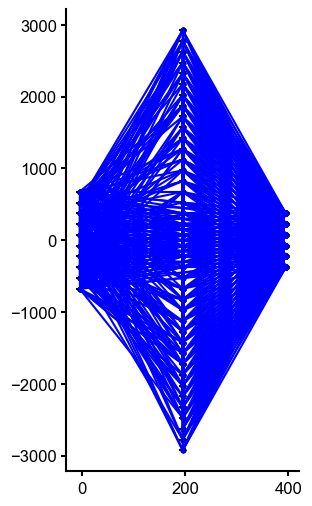

In [5]:
net.compute_xyz()
net.rotate(180)
net.arrange_in_layers(layers=[n_inh, num_cells-n_out-n_inh, n_out], within_layer_offset=150, between_layer_offset=200)

fig, ax = plt.subplots(1, 1, figsize=(3, 6))
_ = net.vis(ax=ax, detail="full")




Added 1 external_states. See `.externals` for details.
Added 1 external_states. See `.externals` for details.
Added 1 external_states. See `.externals` for details.
Added 1 external_states. See `.externals` for details.
Added 1 external_states. See `.externals` for details.
Added 1 external_states. See `.externals` for details.
Added 1 external_states. See `.externals` for details.
Added 1 external_states. See `.externals` for details.
Added 1 external_states. See `.externals` for details.
Added 1 external_states. See `.externals` for details.
Added 56 recordings. See `.recordings` for details.


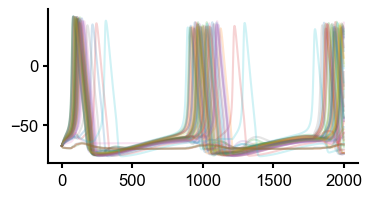

In [6]:
# Stimulus.
i_delay = 3.0  # ms
i_amp = 0.05  # nA
i_dur = 2.0  # ms

# Duration and step size.
dt = 0.025  # ms
t_max = 50.0  # ms
time_vec = jnp.arange(0.0, t_max + dt, dt)

current = jx.step_current(i_delay, i_dur, i_amp, dt, t_max)
for stim_ind in range(10):
    net.cell(stim_ind).branch(0).loc(0.0).stimulate(current)

net.cell(np.arange(num_cells)).branch(0).loc(0.0).record()

s = jx.integrate(net, delta_t=dt)
fig, ax = plt.subplots(1, 1, figsize=(4, 2))
_ = ax.plot(s[:-2].T,alpha=.2)
#_ = ax.plot(s[-1].T,color='black')
#_ = ax.plot(s[-2].T,color='black')


In [7]:
# needed!
net.delete_stimuli()
net.delete_recordings()


In [8]:
in_conn_prob=.1



In [9]:
n_inp = n_classes + 1 #stimuli and fixation
input_weights = abs(np.random.uniform(0, 1, size = (n_rec,n_inp))) * RNN_params['inp_scale']
if in_conn_prob < 1.0:
    input_weights_mask = np.zeros((n_rec,n_inp))
    for i in range(n_inp):
        n_nonzero = int(n_rec*in_conn_prob)
        nonzero_indices = np.random.choice(np.arange(n_rec), size=n_nonzero, replace=False)
        input_weights_mask[nonzero_indices, i] = 1
else:
    input_weights_mask = np.ones((n_rec,n_inp))
input_weights = [{"input_weights": jnp.asarray(input_weights)}]

In [10]:
print(np.sum(input_weights_mask>0,axis=0))

[5 5 5 5 5 5 5]


In [11]:
task = Reaching(task_params=task_params,
)

In [12]:
import jaxley.optimize.transforms as jt

In [13]:
input_weights_min = training_params['lowers']['input_weights']
input_weights_max = training_params['uppers']['input_weights']
IonotropicSynapse_k_minus_min = training_params['lowers']['IonotropicSynapse_k_minus']
IonotropicSynapse_k_minus_max = training_params['uppers']['IonotropicSynapse_k_minus']


In [14]:
input_weights_max

4

In [15]:
input_weights_min

0

In [16]:
b = 1/np.mean(abs(conn_matrix.flatten()[np.nonzero(conn_matrix.flatten())]))
print(b)

10107.59546971261


In [17]:
b=10

In [18]:
tf = jx.ParamTransform([{"input_weights": jt.SigmoidTransform(input_weights_min, input_weights_max)},
                        {"IonotropicSynapse_gS":jt.ChainTransform([jt.AffineTransform(b, 0),
                                                                    jt.SoftplusTransform(0),
                                                                    jt.AffineTransform(1/b, 0)
                                                                   ]
                                                                   )},
                        {"IonotropicSynapse_k_minus" : jt.SigmoidTransform(IonotropicSynapse_k_minus_min, IonotropicSynapse_k_minus_max)}])


def label_params(opt_params):
    """Assign parameter group labels for optax.multi_transform."""
    def label_fn(param_dict):
        if "input_weights" in param_dict:
            return "weights"
        if "IonotropicSynapse_gS" in param_dict:
            return "gS"
        if "IonotropicSynapse_k_minus" in param_dict:
            return "kminus"
        if "v" in param_dict:
            return "v"
        return "other"
    return jax.tree_util.tree_map(label_fn, opt_params)

def init_opt(opt_params, base_lr):
    # Per-group optimizers
    transforms = {
        "weights": optax.adam(base_lr * 1.0),
        "gS": optax.adam(base_lr * 0.01),     # much smaller LR
        "kminus": optax.adam(base_lr * 1.0),
        "v": optax.adam(base_lr * 0.1),
        "other": optax.adam(base_lr),         # fallback
    }

    labels = label_params(opt_params)

    gradient_transform = optax.chain(
        optax.clip_by_global_norm(1.0),
        optax.multi_transform(transforms, labels),
    )
    opt_state = gradient_transform.init(opt_params)
    return opt_state, gradient_transform


In [19]:
from jax.flatten_util import ravel_pytree


In [27]:
# make network trainable
net.IonotropicSynapse.edge("all").make_trainable("IonotropicSynapse_gS")
if training_params['train_k_minus']:
    net.IonotropicSynapse.edge("all").make_trainable("IonotropicSynapse_k_minus")
if training_params['train_v']:
    for i in range(num_cells):
        net.cell(i).make_trainable("v")
params = net.get_parameters()

params = input_weights + params
#init_params = params.copy()
#init_params.append({'conn_matrix':conn_matrix})

opt_params = tf.inverse(params)
net.delete_recordings()

# record from readouts
for i in range(RNN_params['n_out']):
    net.cell([RNN_params['n_rec']+i]).branch(0).comp(0).record(verbose=False)
# Create simulation / training functions
levels = training_params['checkpoint_levels']

def simulate(params, stim):
    """run simulation given stimuli"""
    input_weights = params[0]["input_weights"]*input_weights_mask
    syn_weights = params[1:]

    data_stimuli = None
    for i, w in zip(range(RNN_params["n_rec"]), input_weights):
        data_stimuli= net.cell(i).data_stimulate(
            jnp.inner(stim,w), data_stimuli=data_stimuli
        )
    num_timesteps = stim.shape[0]
    checkpoints = [int(np.ceil(num_timesteps ** (1/levels))) for _ in range(levels)]
    v = jx.integrate(
        net,
        delta_t=dt,
        params=syn_weights,
        data_stimuli=data_stimuli,
        solver="bwd_euler",
        checkpoint_lengths=checkpoints,
    )
    return v

def predict(opt_params, stim):
    """extract prediction (readout units activation)"""
    v = simulate(opt_params, stim)
    return ((v[-n_classes:])).T


def softmax(x, axis=1, eps=1e-8):
    """Numerically stable softmax over classes (axis=0)."""
    x_max = jnp.max(x, axis=axis, keepdims=True)
    e_x = jnp.exp(x - x_max)
    e_x /= jnp.sum(e_x, axis=axis, keepdims=True)
    return jnp.clip(e_x, eps, 1 - eps)


def ce(pred, label, mask):
    """
    Cross-entropy loss for one-hot labels (single trial).
    Args:
        pred:  (T, n_classes)
        label: (T, n_classes)
        mask:  (T,1)
    """
    probs = softmax(pred, axis=1)  # softmax over classes at each time
    log_likelihood = jnp.sum(label * jnp.log(probs), axis=1)  # (T,)
    mask = mask.squeeze(-1)
    loss = -jnp.sum(mask * log_likelihood) / jnp.sum(mask)
    return loss


def accuracy(pred, label, mask):
    """
    Compute accuracy for a single trial.
    Args:
        pred:  (T, n_classes)
        label: (T, n_classes)
        mask:  (T, 1)
    """
    probs = softmax(pred, axis=1)
    pred_class = jnp.argmax(probs, axis=1)   # (T,)
    true_class = jnp.argmax(label, axis=1)   # (T,)

    mask = mask.squeeze(-1)
    correct = (pred_class == true_class) * mask
    acc = jnp.sum(correct) / jnp.sum(mask)
    return acc

def loss_fn(opt_params, stim, label, mask):
    """Compute loss and accuracy for optimization.
    Args:
        opt_params: parameters in the transformed space
        stim:  (T-1, n_classes+1)
        label: (T, n_classses)
        mask:  (T, 1)
    """
#

    params = tf.forward(opt_params)
    pred = predict(params, stim)
    loss_val = ce(pred, label, mask)
    acc_val = accuracy(pred, label, mask)
    return loss_val, acc_val

vmapped_loss_fn = vmap(loss_fn, in_axes=(None, 0, 0, 0))

def batched_loss_fn(params, stims, labels, masks):
    """mean loss over batch of trials"""
    all_loss_vals,all_accs = vmapped_loss_fn(params, stims, labels, masks)
    return jnp.mean(all_loss_vals),jnp.mean(all_accs)

#grad_fn = jit(value_and_grad(batched_loss_fn, argnums=0, has_aux=True))
grad_fn = (value_and_grad(batched_loss_fn, argnums=0, has_aux=True))

# initialise optimizer
def init_opt(opt_params, lr):

    # Exponential decay of the learning rate.
    scheduler = optax.exponential_decay(
        init_value=lr,
        transition_steps=1,
        decay_rate=0.995,
        end_value=training_params['lr_end'])

    # Combining gradient transforms using `optax.chain`.
    gradient_transform = optax.chain(
        optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
        optax.scale_by_adam(),  # Use the updates from adam.
        optax.scale_by_schedule(scheduler),  # Use the learning rate from the scheduler.
        optax.scale(-1.0)
    )
    opt_state = gradient_transform.init(opt_params)
    return opt_state, gradient_transform



Number of newly added trainable parameters: 828. Total number of trainable parameters: 2484
Number of newly added trainable parameters: 828. Total number of trainable parameters: 3312


ValueError: List arity mismatch: 3 != 5; list: [{'input_weights': <jaxley.optimize.transforms.SigmoidTransform object at 0x155abf750>}, {'IonotropicSynapse_gS': <jaxley.optimize.transforms.ChainTransform object at 0x1677d2650>}, {'IonotropicSynapse_k_minus': <jaxley.optimize.transforms.SigmoidTransform object at 0x155472110>}].

In [21]:
net.delete_recordings()
for i in range(RNN_params['n_rec']+RNN_params['n_out']):
    net.cell(i).branch(0).comp(0).record(verbose=False)

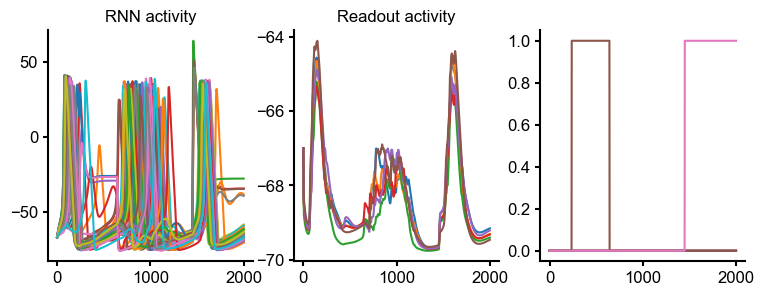

In [22]:
stim, target, mask = task.get_batch()
fig,ax = plt.subplots(1,3,figsize=(9,3))
for i in range(1):
    params=tf.forward(opt_params)
    v= simulate(params, stim[i])
    ax[0].plot(v[:RNN_params['n_rec']].T)#,aspect='auto')
    ax[1].plot(v[RNN_params['n_rec']:].T)
    ax[2].plot(stim[i])
    ax[0].set_title('RNN activity')
    ax[1].set_title('Readout activity')

ax[1].spines[['top','right']].set_visible(False)


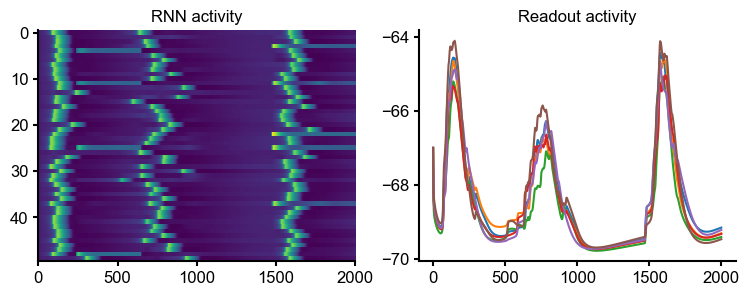

In [23]:
stim, target, mask = task.get_batch()
fig,ax = plt.subplots(1,2,figsize=(9,3))
for i in range(1):
    params = tf.forward(opt_params)

    v= simulate(params, stim[i])
    ax[0].imshow(v[:RNN_params['n_rec']],aspect='auto')
    ax[1].plot(v[RNN_params['n_rec']:].T)
    ax[0].set_title('RNN activity')
    ax[1].set_title('Readout activity')
ax[1].spines[['top','right']].set_visible(False)


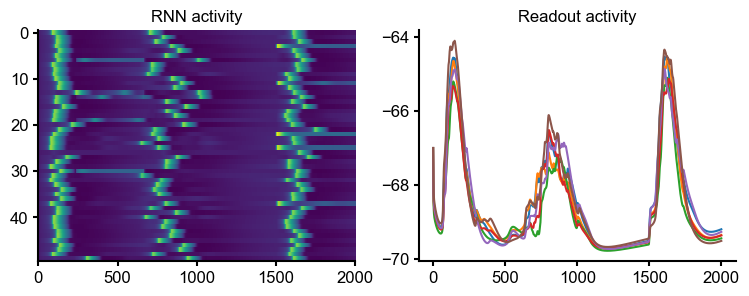

In [24]:
stim, target, mask = task.get_batch()
fig,ax = plt.subplots(1,2,figsize=(9,3))
for i in range(1):
    params = tf.forward(opt_params)
    v= simulate(params, stim[i])
    ax[0].imshow(v[:RNN_params['n_rec']],aspect='auto')
    ax[1].plot(v[RNN_params['n_rec']:].T)
    ax[0].set_title('RNN activity')
    ax[1].set_title('Readout activity')
ax[1].spines[['top','right']].set_visible(False)


In [25]:
net.delete_recordings()
for i in range(RNN_params['n_out']):
    net.cell([RNN_params['n_rec']+i]).branch(0).comp(0).record(verbose=False)

In [26]:

opt_state, optimizer = init_opt(opt_params, lr = training_params['lr'])

lowest_loss = 10
highest_acc = 0

for i in range(training_params['max_epochs']):
    stim, target, mask = task.get_batch()
    #with jax.checking_leaks():
    (l,a), g = grad_fn(opt_params, stim[:,1:], target, mask)
    flat_g, _ = ravel_pytree(g)
    print("Global grad norm:", jnp.linalg.norm(flat_g))
    if i % 1 == 0:
        print(f"it {i}, loss {l}, acc {a}")
        
    if np.isnan(l):
        print("loss is nan")
        break

    # Define Curriculum
    if l<training_params['loss_threshold'] and a>  training_params['acc_threshold'] and task.params["delay"][1]<19000:
        print(f"it {i}, loss {l}, acc {a}")    
        #task.params["delay"][0]+=training_params['delay_step']
        #task.params["delay"][1]+=training_params['delay_step']
        print("increasing delay to :" + str(task.params["delay"][1]))
   
    for para, grad in zip(opt_params, g):
        if para.keys()!=grad.keys():
            print("keys do not match")
            break
        if 'input_weights' in para.keys():
            inp_ws = para['input_weights']
            print(f"param: masked input_weights, grad_norm: {l2_norm(grad['input_weights'][input_weights_mask>0])}, param_norm: {l2_norm(para['input_weights'][input_weights_mask>0])}, "
                        f"min_param_val: {jnp.min(para['input_weights'][input_weights_mask>0])}, max_param_val: {jnp.max(para['input_weights'][input_weights_mask>0])}")
        else:
            print(f"param: {para.keys()}, grad_norm: {l2_norm(grad)}, param_norm: {l2_norm(para)}, "
                f"min_param_val: {jnp.min(jnp.array(list(para.values())))}, max_param_val: {jnp.max(jnp.array(list(para.values())))}")

    updates, opt_state = optimizer.update(g, opt_state)
    opt_params = optax.apply_updates(opt_params, updates)



(2000, 6)
(2000, 6)
(2000, 1)
(1999, 7)


TypeError: mul got incompatible shapes for broadcasting: (2000,), (6,).

In [ ]:
for para, grad in zip(opt_params, g):
    if para.keys()!=grad.keys():
        print("keys do not match")
        break
    if 'input_weights' in para.keys():
        inp_ws = para['input_weights']
        print(f"param: masked input_weights, grad_norm: {l2_norm(grad['input_weights'][input_weights_mask>0])}, param_norm: {l2_norm(para['input_weights'][input_weights_mask>0])}, "
                    f"min_param_val: {jnp.min(para['input_weights'][input_weights_mask>0])}, max_param_val: {jnp.max(para['input_weights'][input_weights_mask>0])}")
    else:
        print(f"param: {para.keys()}, grad_norm: {l2_norm(grad)}, param_norm: {l2_norm(para)}, "
            f"min_param_val: {jnp.min(jnp.array(list(para.values())))}, max_param_val: {jnp.max(jnp.array(list(para.values())))}")

updates, opt_state = optimizer.update(g, opt_state)
opt_params = optax.apply_updates(opt_params, updates)
